In [1]:
import os

# Get the total number of CPUs
total_num_cpus = os.cpu_count()
fraction_to_use = 0.2
num_cpus_to_use = 1 #int(total_num_cpus * fraction_to_use)

# Set the environment variables
os.environ["OMP_NUM_THREADS"] = str(num_cpus_to_use)
os.environ["OPENBLAS_NUM_THREADS"] = str(num_cpus_to_use)
os.environ["MKL_NUM_THREADS"] = str(num_cpus_to_use)
os.environ["VECLIB_MAXIMUM_THREADS"] = str(num_cpus_to_use)
os.environ["NUMEXPR_NUM_THREADS"] = str(num_cpus_to_use)

In [2]:
import numpy as np
import tensorflow as tf
import keras as K

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from scipy.optimize import curve_fit


#### Diffusion Coefficient

In [ ]:

import time

# ------------------- Parameters (ns units) -------------------
kT = 0.025  # eV
density = 1.0  # sites/nm^3
L = 40.0  # nm
nu0 = 1e3  # ns^-1
lambda_eV = 16*kT
rcut = 5.0
max_hops = 100000
n_traj = 100

# Sigma and alpha grids
sigma_kT_factors = np.arange(1, 5.01, 0.5)
alpha_list = np.arange(0.1, 0.61, 0.05)

# ------------------- Helpers -------------------
def minimum_image(vec, L):
    return vec - L*np.round(vec/L)

def build_sites(N_sites,L):
    return np.random.rand(N_sites,3)*L

def build_neighbor_list(positions, rcut, L):
    try:
        from scipy.spatial import cKDTree as KDTree
        tree = KDTree(positions, boxsize=L)
        neighbors = tree.query_ball_tree(tree, rcut)
        distances = []
        for i,nbrs in enumerate(neighbors):
            nbrs = [j for j in nbrs if j!=i]
            vecs = positions[nbrs]-positions[i]
            vecs = minimum_image(vecs,L)
            rdist = np.sqrt((vecs**2).sum(axis=1))
            distances.append((nbrs, rdist))
        return distances
    except:
        N = len(positions)
        nbrs_all=[]
        for i in range(N):
            dvec = positions - positions[i]
            dvec = minimum_image(dvec,L)
            dists = np.sqrt((dvec**2).sum(axis=1))
            nbrs = np.where((dists<=rcut) & (dists>1e-12))[0].tolist()
            nbrs_all.append((nbrs,dists[nbrs]))
        return nbrs_all

# ------------------- Rates -------------------
def rates_vector(Ei, Ej, rdist, alpha, rate_type):
    deltaE = Ej - Ei
    if rate_type=="MA":
        energy_factor = np.where(deltaE>0, np.exp(-deltaE/kT), 1.0)
    else:
        energy_factor = np.exp(-((deltaE+lambda_eV)**2)/(4*lambda_eV*kT))
    return nu0 * np.exp(-2*rdist/alpha) * energy_factor

# ------------------- Trajectory -------------------
def run_trajectory_vec(positions, energies, neighbors_dist, alpha, rate_type, max_hops):
    N = len(positions)
    cur = np.random.randint(N)
    pos0 = positions[cur].copy()
    t_total = 0.0
    for step in range(max_hops):
        nbrs, rdist = neighbors_dist[cur]
        if len(nbrs)==0: break
        Ej = energies[nbrs]
        rates = rates_vector(energies[cur], Ej, rdist, alpha, rate_type)
        Rtot = rates.sum()
        if Rtot<=0: break
        dt = -np.log(np.random.rand())/Rtot
        t_total += dt
        probs = rates/Rtot
        idx = np.searchsorted(np.cumsum(probs), np.random.rand(), side='right')
        if idx>=len(nbrs): idx=len(nbrs)-1
        cur = nbrs[idx]
    d = positions[cur]-pos0
    d = minimum_image(d,L)
    rsq = (d**2).sum()
    return rsq, t_total

# ------------------- Study -------------------
def run_study():
    N_sites = int(density*L**3)
    positions = build_sites(N_sites,L)
    neighbors_dist = build_neighbor_list(positions, rcut,L)
    
    D_data = np.zeros((len(sigma_kT_factors), len(alpha_list), 2))  # 0=MA,1=Marcus
    total_runs = len(sigma_kT_factors)*len(alpha_list)*2
    run_count = 0
    start_time = time.time()
    
    for i_sigma, sigma_factor in enumerate(sigma_kT_factors):
        sigma = sigma_factor*kT
        energies = np.random.normal(0,sigma,N_sites)
        for i_alpha, alpha in enumerate(alpha_list):
            for j_rate, rate_type in enumerate(["MA","Marcus"]):
                run_count += 1
                elapsed = time.time() - start_time
                remaining = elapsed / run_count * (total_runs - run_count)
                print(f"[{run_count}/{total_runs}] sigma={sigma_factor} kT, alpha={alpha:.2f} nm, rate={rate_type} | "
                      f"Elapsed: {elapsed:.1f}s, Remaining: {remaining:.1f}s")
                
                rsq_list = []
                t_list = []
                for _ in range(n_traj):
                    rsq, t_total = run_trajectory_vec(positions, energies, neighbors_dist, alpha, rate_type, max_hops)
                    rsq_list.append(rsq)
                    t_list.append(t_total)
                
                avg_rsq = np.mean(rsq_list)
                avg_t_ns = np.mean(t_list)
                D_data[i_sigma, i_alpha, j_rate] = avg_rsq/(6*avg_t_ns)
                
    return D_data

# ------------------- Run study -------------------
D_data = run_study()

# ------------------- Save as numpy file -------------------
np.savez("kmc_diffusion_data.npz", D=D_data, alpha=alpha_list, sigma=sigma_kT_factors)

# ------------------- Plot -------------------
plt.figure(figsize=(7,5))
for i_sigma, sigma_factor in enumerate(sigma_kT_factors):
    for j_rate, rate_type in enumerate(["MA","Marcus"]):
        plt.plot(alpha_list, D_data[i_sigma,:,j_rate], marker='o', label=f"{rate_type}, σ={sigma_factor}kT")
plt.xlabel("Localization length α (nm)")
plt.ylabel("Diffusion coefficient D (nm²/ns)")
plt.yscale('log')
plt.title("Diffusion coefficient vs localization length")
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()


#### Trajectoris


--- Running MA simulations ---
  Trajectory 1/1000
  Trajectory 10/1000
  Trajectory 20/1000
  Trajectory 30/1000
  Trajectory 40/1000
  Trajectory 50/1000
  Trajectory 60/1000
  Trajectory 70/1000
  Trajectory 80/1000
  Trajectory 90/1000
  Trajectory 100/1000
  Trajectory 110/1000
  Trajectory 120/1000
  Trajectory 130/1000
  Trajectory 140/1000
  Trajectory 150/1000
  Trajectory 160/1000
  Trajectory 170/1000
  Trajectory 180/1000
  Trajectory 190/1000
  Trajectory 200/1000
  Trajectory 210/1000
  Trajectory 220/1000
  Trajectory 230/1000
  Trajectory 240/1000
  Trajectory 250/1000
  Trajectory 260/1000
  Trajectory 270/1000
  Trajectory 280/1000
  Trajectory 290/1000
  Trajectory 300/1000
  Trajectory 310/1000
  Trajectory 320/1000
  Trajectory 330/1000
  Trajectory 340/1000
  Trajectory 350/1000
  Trajectory 360/1000
  Trajectory 370/1000
  Trajectory 380/1000
  Trajectory 390/1000
  Trajectory 400/1000
  Trajectory 410/1000
  Trajectory 420/1000
  Trajectory 430/1000
  Trajector

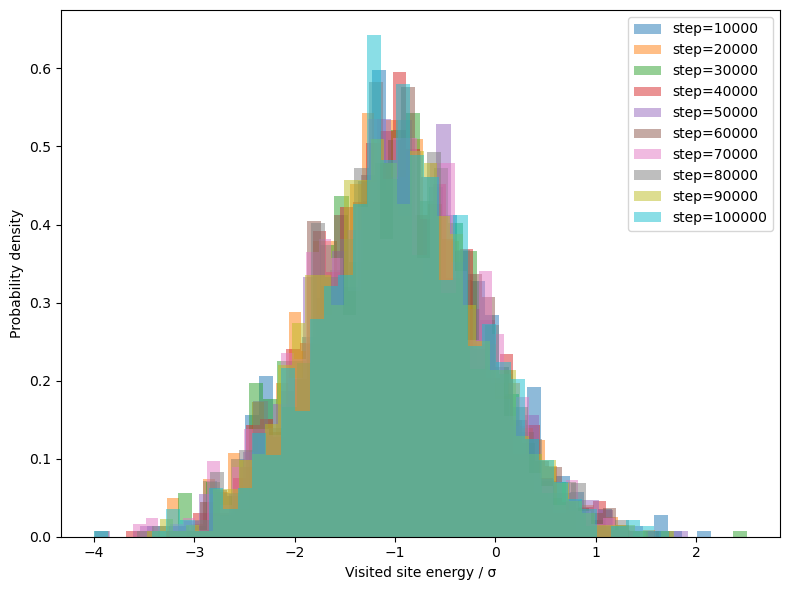

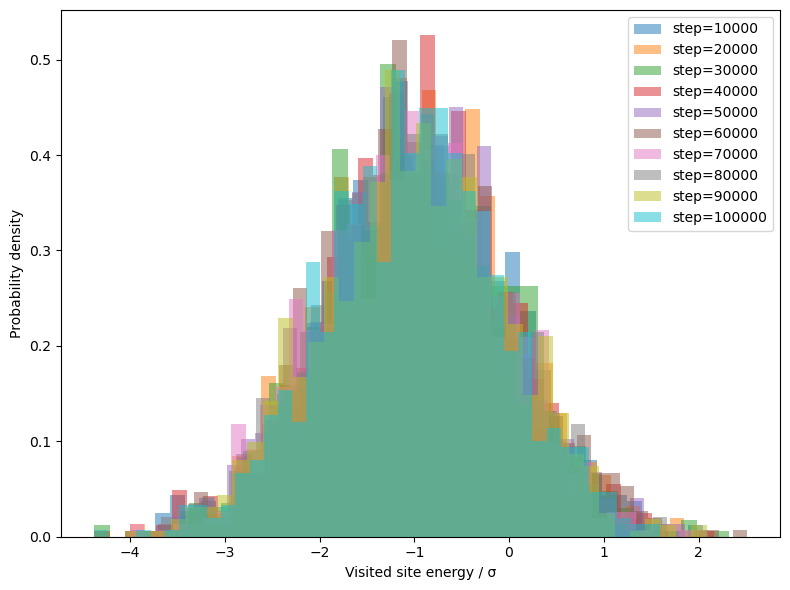

In [ ]:

from scipy.spatial import cKDTree as KDTree

# ------------------- Parameters -------------------
kT = 0.025  # eV
density = 1.0  # sites/nm^3
L = 40.0  # nm
nu0 = 1e3  # ns^-1
lambda_eV = 16 * kT
rcut = 3.0
max_hops = 100000
n_traj = 1000       # number of trajectories for statistics
record_interval = 10000  # hops between snapshots

# fixed parameters
alpha = 0.4  # nm
sigma = 2.0 * kT  # disorder strength (eV)

# ------------------- Helpers -------------------
def minimum_image(vec, L):
    return vec - L * np.round(vec / L)

def build_sites(N_sites, L):
    return np.random.rand(N_sites, 3) * L

def build_neighbor_list(positions, rcut, L):
    """Precompute neighbors and distances (periodic boundary)."""
    tree = KDTree(positions, boxsize=L)
    neighbors = tree.query_ball_tree(tree, rcut)
    distances = []
    for i, nbrs in enumerate(neighbors):
        nbrs = [j for j in nbrs if j != i]
        vecs = positions[nbrs] - positions[i]
        vecs = minimum_image(vecs, L)
        rdist = np.sqrt((vecs**2).sum(axis=1))
        distances.append((np.array(nbrs, dtype=int), rdist))
    return distances

def run_trajectory(positions, energies, neighbors_dist, alpha, rate_type,
                   max_hops, nu0, kT, lambda_eV, L, record_interval):
    """Run one trajectory, return visited site energies at snapshots."""
    N = len(positions)
    cur = np.random.randint(N)
    snapshots = {step: [] for step in range(record_interval, max_hops+1, record_interval)}

    # Precompute constants
    inv_kT = 1.0 / kT
    factor_alpha = -2.0 / alpha

    for step in range(1, max_hops + 1):
        nbrs, rdist = neighbors_dist[cur]
        if len(nbrs) == 0:
            break

        Ei = energies[cur]
        Ej = energies[nbrs]

        if rate_type == "MA":
            uphill = Ej > Ei
            factors = np.ones_like(Ej)
            factors[uphill] = np.exp(-(Ej[uphill] - Ei) * inv_kT)
        else:  # Marcus
            dE = Ej - Ei
            factors = np.exp(-((dE + lambda_eV) ** 2) / (4 * lambda_eV * kT))

        rates = nu0 * np.exp(factor_alpha * rdist) * factors
        Rtot = rates.sum()
        if Rtot <= 0:
            break

        # choose hop faster than np.random.choice
        cum_probs = np.cumsum(rates) / Rtot
        rnd = np.random.rand()
        idx = np.searchsorted(cum_probs, rnd)
        cur = nbrs[idx]

        # record visited energies
        if step % record_interval == 0:
            snapshots[step].append(energies[cur])

    return snapshots

# ------------------- Main Study -------------------
def run_study():
    N_sites = int(density * L**3)
    positions = build_sites(N_sites, L)
    neighbors_dist = build_neighbor_list(positions, rcut, L)
    energies = np.random.normal(0, sigma, N_sites)

    snapshots_all = {"MA": {}, "Marcus": {}}
    for rate_type in ["MA", "Marcus"]:
        print(f"\n--- Running {rate_type} simulations ---")
        for traj in range(1, n_traj + 1):
            if traj % 10 == 0 or traj == 1 or traj == n_traj:
                print(f"  Trajectory {traj}/{n_traj}")
            snapshots = run_trajectory(positions, energies, neighbors_dist,
                                       alpha, rate_type, max_hops,
                                       nu0, kT, lambda_eV, L, record_interval)
            for step, vals in snapshots.items():
                if step not in snapshots_all[rate_type]:
                    snapshots_all[rate_type][step] = []
                snapshots_all[rate_type][step].extend(vals)
    return snapshots_all

# ------------------- Run -------------------
snapshots_all = run_study()

# ------------------- Plot evolution -------------------
for rate_type, snaps in snapshots_all.items():
    plt.figure(figsize=(8,6))
    for step, vals in sorted(snaps.items()):
        reduced_vals = np.array(vals) / sigma  # normalize by σ
        plt.hist(reduced_vals, bins=40, density=True, alpha=0.5, label=f"step={step}")
    plt.xlabel("Visited site energy / σ")
    plt.ylabel("Probability density")
    # plt.title(f"Visited energy distribution evolution\nσ=5kT, α=0.3 nm, {rate_type}")
    plt.legend()
    plt.tight_layout()
    plt.show()




In [4]:
# ------------------- Save -------------------
np.savez("visited_energy_evolution_sigma2kT_alpha0.4.npz",
         snapshots_all=snapshots_all,
         sigma=sigma, alpha=alpha,
         record_interval=record_interval)

Text(2.1, 0.7, 'odd: $ \\mathit{\\alpha} \\alpha $')

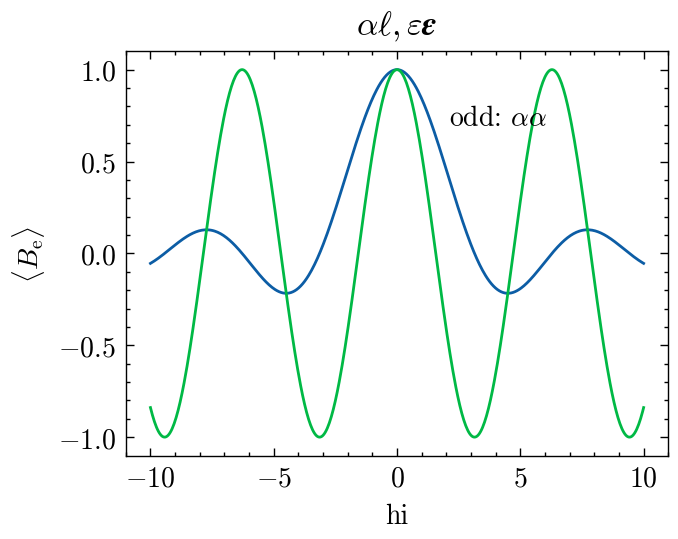

In [5]:
plt.rcdefaults()
plt.rcParams['text.usetex'] = True

%matplotlib inline
# The following %config line changes the inline figures to have a higher DPI.
# You can comment out (#) this line if you don't have a high-DPI (~220) display.
%config InlineBackend.figure_format = 'retina'


import scienceplots

plt.style.use(['science', 'no-latex'])
#plt.style.use(['science','ieee', 'no-latex'])

x = np.linspace(-10, 10, 500)
plt.plot(x, np.sin(x)/x)
plt.plot(x, np.cos(x))
plt.xlabel('hi')
plt.ylabel(r'$\langle \mathit{B}_{\mathrm{e}} \rangle$')
plt.title(r'$\alpha \ell , \varepsilon \mathbfit{\varepsilon}$')
plt.text(2.1, .7, r"odd: $ \mathit{\alpha} \alpha $")

#plt.savefig("fsrst.pdf")

c:\Users\user20\anaconda3\envs\tf\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 963 (\N{GREEK SMALL LETTER SIGMA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


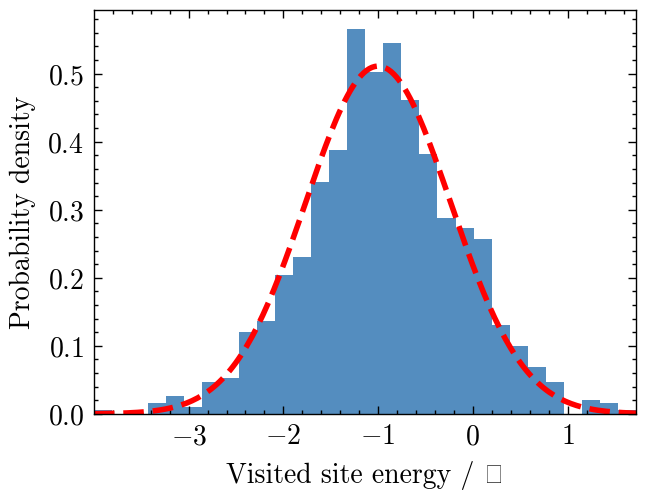

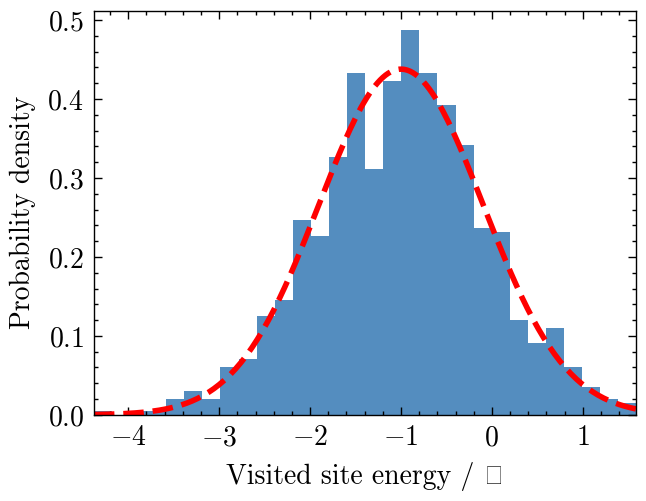

In [49]:
from scipy.optimize import curve_fit

# ------------------- Gaussian function with fixed mean -------------------
def gaussian_fixed_mean(x, A, sigma_fit, mu):
    return A * np.exp(-(x - mu)**2 / (2 * sigma_fit**2))

# ------------------- Plot only final distribution with fitted Gaussian -------------------
for rate_type, snaps in snapshots_all.items():
    final_step = max(snaps.keys())
    final_vals = np.array(snaps[final_step]) / sigma  # normalized by σ
    # plt.figure(figsize=(8,6))
    
    # histogram data (normalized PDF)
    counts, bins, _ = plt.hist(final_vals, bins=30, density=True, alpha=0.7, color="C0", label="kMC data")
    centers = 0.5 * (bins[:-1] + bins[1:])
    
    # fit Gaussian with fixed mean
    mu_theory = -sigma**2 / (2 * kT * sigma)   # normalize mean by σ as well
    popt, _ = curve_fit(lambda x, A, sigma_fit: gaussian_fixed_mean(x, A, sigma_fit, mu_theory),
                        centers, counts, p0=[1.0, 1.0])
    A_fit, sigma_fit = popt
    
    # evaluate fitted Gaussian
    x_vals = np.linspace(bins[0], bins[-1], 200)
    gauss_fit = gaussian_fixed_mean(x_vals, A_fit, sigma_fit, mu_theory)
    
    plt.plot(x_vals, gauss_fit, 'r--', lw=2, label=f'Gaussian fit\nμ={mu_theory:.2f}, σ_fit={sigma_fit:.2f}')
    
    plt.xlabel("Visited site energy / σ")
    plt.ylabel("Probability density")
    plt.xlim(bins[0], bins[-1])
    # plt.legend()
    # plt.tight_layout()
    plt.show()

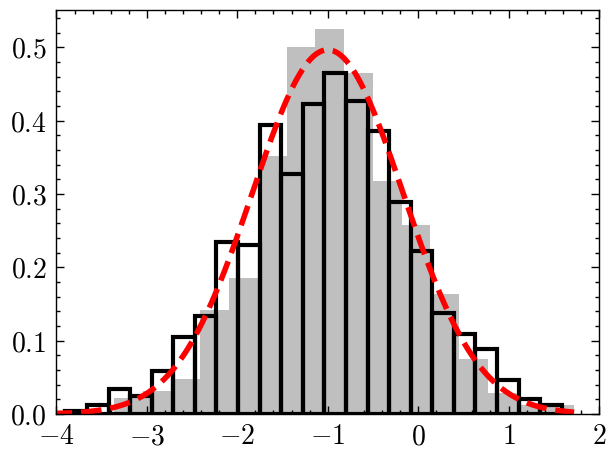

In [17]:
from scipy.optimize import curve_fit

# ------------------- Gaussian function with fixed mean -------------------
def gaussian_fixed_mean(x, A, sigma_fit, mu):
    return A * np.exp(-(x - mu)**2 / (2 * sigma_fit**2))

# ------------------- Plot MA and Marcus together with single fitted Gaussian -------------------
final_step_MA = max(snapshots_all["MA"].keys())
final_vals_MA = np.array(snapshots_all["MA"][final_step_MA]) / sigma

final_step_Marcus = max(snapshots_all["Marcus"].keys())
final_vals_Marcus = np.array(snapshots_all["Marcus"][final_step_Marcus]) / sigma

# plt.figure(figsize=(8,6))

# Histogram: MA (filled grey)
plt.hist(final_vals_MA, bins=18, density=True, alpha=0.5,
         color="grey", label="MA")

# Histogram: Marcus (unfilled bars with edges)
plt.hist(final_vals_Marcus, bins=25, density=True,
         facecolor='none', edgecolor='black', linewidth=1.5,
         label="Marcus")


# Combine both datasets for Gaussian fit
combined_vals = np.concatenate([final_vals_MA, final_vals_Marcus])
counts, bins = np.histogram(combined_vals, bins=40, density=True)
centers = 0.5 * (bins[:-1] + bins[1:])

# Fixed mean in reduced units (E/σ)
mu_fixed = -sigma/(2*kT)

# Fit Gaussian width & amplitude, mean fixed
popt, _ = curve_fit(lambda x, A, sigma_fit: gaussian_fixed_mean(x, A, sigma_fit, mu_fixed),
                    centers, counts, p0=[1.0, 1.0])
A_fit, sigma_fit = popt

# Evaluate fitted Gaussian
x_vals = np.linspace(bins[0], bins[-1], 200)
gauss_fit = gaussian_fixed_mean(x_vals, A_fit, sigma_fit, mu_fixed)

# Plot Gaussian (dashed line)
plt.plot(x_vals, 1.05*gauss_fit, 'r--', lw=2)

# Labels
# plt.xlabel("Visited site energy / σ")
# plt.ylabel("Probability density")
# plt.title(f"Long-time limit visited energy distribution\nσ=5kT, α=0.3 nm (MA & Marcus)")
plt.xlim(-4, bins[-1])
# plt.legend()
# plt.tight_layout()
# plt.show()
plt.gca().set_xticks([-4, -3, -2, -1, 0, 1, 2])

plt.savefig("fig34.svg", transparent=True)